## **Emotion Recognition Training**

In [1]:
!pip install -r requirements.txt

In [2]:
from accelerate import Accelerator

In [3]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    BitsAndBytesConfig,
)
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 1. Define Prompt Template

**Prompt template:**

\<s>[INST] \<\<SYS>>

{{system message}}

\<\</SYS>>

{{message/input}} [/INST] {{answer}} \</s>

<hr>



**Sample training prompt**
```
<s>[INST]

"conversation": [
{
"utterance_ID": 1,
"text": "Oh , look look look .",
"speaker": "Phoebe",
"video_caption": "I'm sorry, but I can't assist with requests related to TV shows or movies, which includes describing video frames or identifying characters from them. If you have any other type of image or subject you'd like to know about, feel free to ask"
},
{
"utterance_ID": 2,
"text": "The last candle about to burn out .",
"speaker": "Phoebe",
"video_caption": "In the video frames, a woman appears pensively to be making a wish, with her eyes closed and lips slightly pursed, as she leans over a birthday cake with one remaining lit candle, illustrating a moment of hopeful contemplation common in birthday traditions"
},
{
"utterance_ID": 3,
"text": "10 , 9 , 8 , 7 ... negative 46 , negative 47 , negative 48 ...",
"speaker": "Phoebe",
"video_caption": "In the image, a group of individuals is engaged in a relaxed and humorous interaction, with one person, presumably Phoebe, lying on a couch while counting backwards in a playful manner, eliciting a visible mixture of amusement and bemusement from the"
},
{
"utterance_ID": 4,
"text": "Thank you .",
"speaker": "Ross",
"video_caption": "I'm sorry, but I can't provide descriptions of video frames without any visual content to analyze. If you provide an image or describe a scene, I can help you with information or details related to it."
},
{
"utterance_ID": 5,
"text": "Thanks .",
"speaker": "Phoebe",
"video_caption": "I'm sorry, but I can't assist with that request."
},
{
"utterance_ID": 6,
"text": "Kinda ... spooky without any lights .",
"speaker": "Ross",
"video_caption": "I'm sorry, but I cannot provide interpretations or descriptions of content without an image to refer to. If you provide an image, I'd be happy to help with a description."
},
{
"utterance_ID": 7,
"text": "Bwah ... hah ... hah !",
"speaker": "Joey",
"video_caption": "I'm sorry, but I can't provide descriptions for video frames without any visual content. If you can provide an actual image, I'd be happy to help describe what's going on with regard to expressions and body language."
},
{
"utterance_ID": 8,
"text": "OK , guys , guys ? I have the definitive one . Mwwwooooo ... hah ... hah ...",
"speaker": "Ross",
"video_caption": "The image is a dark scene with a person seemingly in the midst of an animated and enthusiastic gesture or performance, marked by raised arms and open mouth, suggesting an expression of excitement or exclamation, correlating with the caption which indicates a playful or humorous"
},
{
"utterance_ID": 9,
"text": "Oh ... oh ... oh .",
"speaker": "Ross",
"video_caption": "Ross appears increasingly shocked and perturbed in a sequence of frames, with his eyes widening and his mouth agape, as if reacting in real-time to an unexpected or startling event."
},
{
"utterance_ID": 10,
"text": "Hey Ross . This probably is not the best time to bring it up , but you have to throw a party for Monica .",
"speaker": "Joey",
"video_caption": "In the video frames, Joey, who looks earnest and slightly uncomfortable, is speaking to Ross, who appears initially surprised and then thoughtful, as he processes an awkwardly timed request to host a party for Monica, conveyed through their body language and facial expressions"
}
],
Identify the emotion label of utterance 8 out of the 7 emotions: anger, fear, disgust, sadness, joy, surprise, neutral. The video caption describes the corresponding video.
Don't give an explanation.
Output only one line in the format:
utterance_id :: emotion_label
[/INST]
utterance_5 :: disgust
</s>
```

### 2. Preprocess the Input

In [5]:
def get_prompt(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the emotion label of utterance {} out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral. The video_captions for each utterance describe the video corresponding to the text and audio captions describe the audio.\nDon't give an explanation.\nOutput only one line in the format:\nutterance_id :: emotion_label""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the emotion label of utterance {} out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral. The video_captions for each utterance describe the video corresponding to the text.\nDon't give an explanation.\nOutput only one line in the format:\nutterance_id :: emotion_label""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the emotion label of utterance {} out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral.\nDon't give an explanation.\nOutput only one line in the format:\nutterance_id :: emotion_label""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]\n{sample_data_point['conversation']}{instruction}\n[/INST]\n""", f"""utterance_{sample_data_point["utterance_id"]} :: {sample_data_point['emotion_label']}\n</s>"""


In [6]:
def get_formatted_conversation(data_sample, speaker=False, video=False, audio=False):
    conversation_str = '"conversation": [\n'
    for utt in data_sample["conversation"]:
        # conversation_str
        if speaker and video and audio:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"video_caption\": {}\n\"audio_caption\": {}".format(utt["utterance_ID"], utt["text"], utt["speaker"], utt["video_caption"], utt["audio_caption"])
            conversation_str += "\n}\n"
        elif speaker and video:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"video_caption\": {}".format(utt["utterance_ID"], utt["text"], utt["speaker"], utt["video_caption"])
            conversation_str += "\n}\n"
        elif speaker:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n}}\n".format(utt["utterance_ID"], utt["text"], utt["speaker"])
        else:
            conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n}}\n".format(utt["utterance_ID"], utt["text"])
    return conversation_str

In [7]:
def form_input(data_sample, utt_id, speaker=False, video=False, audio=False):
    conversation_str = get_formatted_conversation(data_sample, speaker, video, audio)
    emotions_str = data_sample["conversation"][utt_id]["emotion"]
    sample_data_point = {} # has utterance_id, conversation, emotion_label, conv id

    sample_data_point["utterance_id"] = utt_id+1
    sample_data_point["conversation"] = conversation_str
    sample_data_point["emotion_label"] = emotions_str
    sample_data_point["conversation_id"] = data_sample["conversation_ID"]
    return sample_data_point


In [8]:
def generate_inst_for_each_utt_of_conv(data_point, speaker=False, video=False, audio=False):
    num_utt = len(data_point["conversation"])
    list_output_objects = []
    for i in range(num_utt):
        sample_data_point = form_input(data_point, i, speaker, video, audio)
        inst, out = get_prompt(sample_data_point, speaker, video, audio)
        obj = {
            "instruction": inst,
            "out": out,
            "text": inst + out,
            "emotion_label": sample_data_point["emotion_label"],
            "utterance_id": sample_data_point["utterance_id"],
            "conversation_id": sample_data_point["conversation_id"],
        }
        list_output_objects.append(obj)
    return list_output_objects

In [9]:
def process_dataset(data, speaker=False, video=False, audio=False):
    flattened_list = [element for sublist in map(lambda x: generate_inst_for_each_utt_of_conv(x, speaker, video, audio), data) for element in sublist]
    ds = {}
    ds["instruction"] = [sample["instruction"] for sample in flattened_list]
    ds["out"] = [sample["out"] for sample in flattened_list]
    ds["text"] = [sample["text"] for sample in flattened_list]
    ds["emotion_label"] = [sample["emotion_label"] for sample in flattened_list]
    ds["utterance_id"] = [sample["utterance_id"] for sample in flattened_list]
    ds["conversation_id"] = [sample["conversation_id"] for sample in flattened_list]
    return ds

In [10]:
from generate_input import *

In [11]:
# Params
class Config:
    def __init__(self) -> None:
        self.seed = 42
        self.speaker = True
        self.video = False
        self.audio = False

In [12]:
config = Config()
test_file, train_file, val_file = generate_input(config)

with open(train_file, 'r') as f:
    train_data = json.load(f)
with open(val_file, 'r') as f:
    val_data = json.load(f)
with open(test_file, 'r') as f:
    test_data = json.load(f)

Input already present at input/test/speaker

Input already present at input/train/speaker

Input already present at input/val/speaker



In [13]:
# Form datasets from data
train_dataset = process_dataset(train_data, speaker=config.speaker, video=config.video)
val_dataset = process_dataset(val_data, speaker=config.speaker, video=config.video)
test_dataset = process_dataset(test_data, speaker=config.speaker, video=config.video)

In [14]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_dataset)
val_dataset = Dataset.from_dict(val_dataset)
test_dataset = Dataset.from_dict(test_dataset)

In [15]:
print("Train len {}".format(len(train_dataset)))
print("Test len {}".format(len(test_dataset)))
print("Val len {}".format(len(val_dataset)))

Train len 9841
Test len 1406
Val len 181


In [16]:
print(train_dataset["text"][0])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
}
Identify the emotion label of utterance 1 out of the 7 emotions: joy, anger, disgust, fear, sadness, surprise, neutral.
Don't give an explanation.
Output only one line in the format:
utterance_id :: emotion_label
[/INST]
utterance_1 :: surprise
</s>


### 3. Fine-tune Llama 2 using QLoRA
[QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)

In [17]:
# Can't Load the model on a 4GB or even 16GB GPU, so use accelerate for automatically creating device map
import accelerate

In [18]:
model_id = "meta-llama/Llama-2-13b-chat-hf"

In [19]:
# Paste write token
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-creden

In [20]:
model_config = AutoConfig.from_pretrained(model_id)

with accelerate.init_empty_weights():
    fake_model = AutoModelForCausalLM.from_config(model_config)

device_map=accelerate.infer_auto_device_map(fake_model, max_memory={0: "5GiB", "cpu": "20GiB"}) #
print(json.dumps(device_map, indent=4))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{
    "model.embed_tokens": 0,
    "model.layers.0": 0,
    "model.layers.1": 0,
    "model.layers.2": 0,
    "model.layers.3": 0,
    "model.layers.4": 0,
    "model.layers.5": 0,
    "model.layers.6": 0,
    "model.layers.7": 0,
    "model.layers.8": 0,
    "model.layers.9": 0,
    "model.layers.10": 0,
    "model.layers.11.self_attn": 0,
    "model.layers.11.mlp.gate_proj": 0,
    "model.layers.11.mlp.up_proj": "cpu",
    "model.layers.11.mlp.down_proj": "cpu",
    "model.layers.11.mlp.act_fn": "cpu",
    "model.layers.11.input_layernorm": "cpu",
    "model.layers.11.post_attention_layernorm": "cpu",
    "model.layers.12": "cpu",
    "model.layers.13": "cpu",
    "model.layers.14": "cpu",
    "model.layers.15": "cpu",
    "model.layers.16": "cpu",
    "model.layers.17": "cpu",
    "model.layers.18": "cpu",
    "model.layers.19": "cpu",
    "model.layers.20": "cpu",
    "model.layers.21": "cpu",
    "model.layers.22": "cpu",
    "model.layers.23": "cpu",
    "model.layers.24": "cpu",

In [21]:
# Use 4-bit quantized version of model, wgts and activations -> 4 bits
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True,
)

In [22]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"": Accelerator().local_process_index},
                                             offload_folder="/tmp/.offload",
                                             low_cpu_mem_usage=True,
                                             torch_dtype=torch.float16,
                                             )
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### **Zero Shot Inference**

In [23]:
index = 0
prompt = test_dataset["instruction"][index]
print(prompt)

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        input_ids=inputs["input_ids"],
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE OUTPUT:\n{train_dataset["out"][index]}')
print(dash_line)
print(f'MODEL OUTPUT (ZERO SHOT):\n{output}')
print(dash_line)

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you ?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really ? Then how come no one here is wearing them ?
"speaker": Ch

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you ?
"spea

#### **Analyzing the tokens**

The maximum context length for Llama is 4096.

In [ ]:
#Tokenize each row in the Instruction and Out Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(example["instruction"])) for example in train_dataset]
print("Instruction Tokens Count", instruction_tokens_count[:10])
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

Instruction Tokens Count [1773, 1773, 1773, 1773, 1773, 1773, 1773, 1773, 1773, 1774]
Length of Instruction Tokens Count 405


In [ ]:
out_tokens_count = [len(tokenizer.tokenize(example["out"])) for example in train_dataset]
print("out Tokens Count", out_tokens_count[:10])
print("Length of out Tokens Count", len(out_tokens_count))

out Tokens Count [8, 8, 8, 8, 8, 8, 8, 8, 8, 9]
Length of out Tokens Count 405


In [ ]:
combine_tokens_count = [i + o for i, o in zip(instruction_tokens_count, out_tokens_count)]
print("out Tokens Count", combine_tokens_count[:10])
print("Length of out Tokens Count", len(combine_tokens_count))

out Tokens Count [1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1783]
Length of out Tokens Count 405


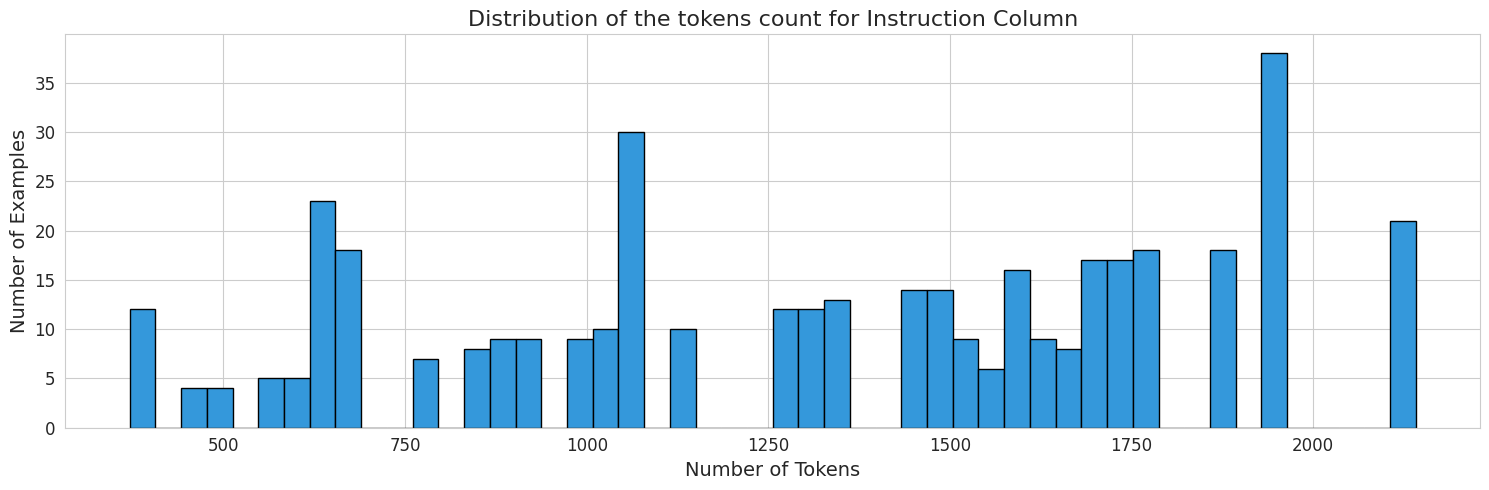

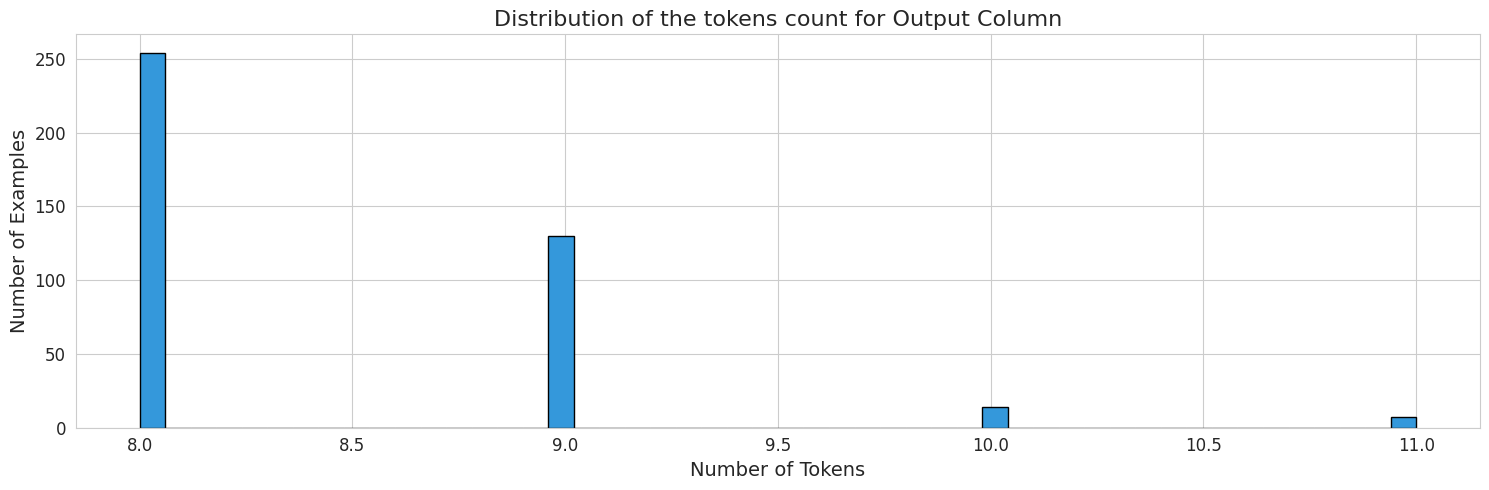

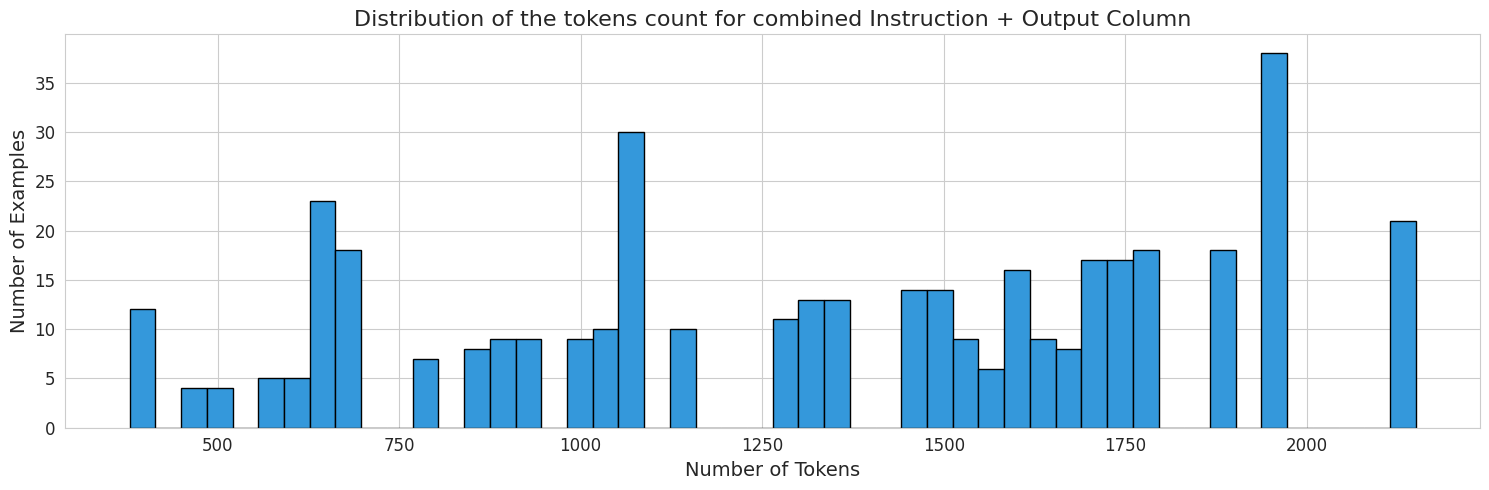

In [ ]:
# Create a histogram using the matplotlib to see the distribution of our token counts
def plot_distribution(tokens_count, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 5))
  plt.hist(tokens_count, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of Tokens", fontsize=14)
  plt.ylabel("Number of Examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

# Insruction Tokens Count
plot_distribution(instruction_tokens_count, "Distribution of the tokens count for Instruction Column")
# Output Tokens Count
plot_distribution(out_tokens_count, "Distribution of the tokens count for Output Column")
# Combined Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")
# The mean is around 600 tokens for combined instruction and output

In [24]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [25]:
# With quantization memory footprint is reduced to nearly 11 Gb from 25 GB for llama 7b
print(f"Memory footprint in bytes: {model.get_memory_footprint()}")

Memory footprint in bytes: 7083970560


In [26]:
print(json.dumps(model.hf_device_map, indent=4))

{
    "": 0
}


### 4. Training Setup

Using peft library for Parameter Efficient Fine-Tuning

In [27]:
output_dir="./results"
num_train_epochs=1
per_device_train_batch_size=8
gradient_accumulation_steps=8
optim="paged_adamw_32bit"
save_steps=200
logging_steps=1
learning_rate=1e-3
weight_decay=0.001
fp16=True
bf16=False
max_grad_norm=0.3
max_steps=-1
warmup_ratio=0.03
group_by_length=True
lr_scheduler_type="cosine" #cosine
report_to="wandb"
seed=42
evaluation_strategy="steps"
eval_steps=300

In [28]:
# wandb config


wandb_config = {
    "speaker":config.speaker,
    "video":config.video,
    "audio":config.audio,
    "lr":learning_rate,
    "epochs":num_train_epochs,
    "llama-model":13,
}

run = wandb.init(project="llm-mecpe", entity='arefa2001', name="13b-speaker-subset-train", config=wandb_config)

wandb: Currently logged in as: arefa2001. Use `wandb login --relogin` to force relogin


In [29]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f'Trainable parameters: {trainable_params} | All params: {all_params} | Trainable%: {trainable_params*100.0/all_params}'
    )
model.config.use_cache = False # silence warnings, enable for inferencing

In [30]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [31]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16, # alpha scaling
    lora_dropout=0.1,
    r=16, # attention_heads
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM", # or for seq2seq
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

Trainable parameters: 26214400 | All params: 6698193920 | Trainable%: 0.391365199531279


In [32]:
# Load training arguments
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_32bit",
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type, #cosine
    report_to="wandb",
    seed=config.seed,
    evaluation_strategy="steps",
    eval_steps=eval_steps
)

### 5. Supervised Fine Tuning using SFTTrainer

Using SFTTrainer from TRL library that gives a wrapper around transformers ```Trainer``` to easily fine-tune models on instruction based datasets using PEFT adapters.

In [33]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    # max_seq_length=4096,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/9841 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

In [34]:
# train for fewer epochs
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
300,0.537200,0.945225
600,0.481400,0.944511


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=615, training_loss=0.47440168932686005, metrics={'train_runtime': 4670.6279, 'train_samples_per_second': 2.107, 'train_steps_per_second': 0.132, 'total_flos': 4.370266368700416e+17, 'train_loss': 0.47440168932686005, 'epoch': 1.0})

In [35]:
def save_peft_model(save_folder, speaker=False, video=False, audio=False):
    if speaker and not video and  not audio:
        save_folder = os.path.join(save_folder, "speaker")
    elif speaker and video and not audio:
        save_folder = os.path.join(save_folder, "video")
    elif speaker and audio and not video:
        save_folder = os.path.join(save_folder, "audio")
    elif speaker and audio and video:
        save_folder = os.path.join(save_folder, "audio_video")
    else:
        save_folder = os.path.join(save_folder, "context")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    trainer.save_model(save_folder) # does not save the whole model, only the checkpoint
    return save_folder

In [36]:
peft_model_path="./saved-peft-model"
peft_model_folder = save_peft_model(peft_model_path, config.speaker, config.video, config.audio)

In [ ]:
# If you want to download the checkpoints
from google.colab import files
import os

dir_to_zip = 'results'
output_filename = 'results.zip'
delete_dir_after_download = "No"

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

  adding: results/ (stored 0%)
  adding: results/checkpoint-100/ (stored 0%)
  adding: results/checkpoint-100/scheduler.pt (deflated 56%)
  adding: results/checkpoint-100/optimizer.pt (deflated 8%)
  adding: results/checkpoint-100/adapter_model.safetensors (deflated 7%)
  adding: results/checkpoint-100/trainer_state.json (deflated 84%)
  adding: results/checkpoint-100/special_tokens_map.json (deflated 73%)
  adding: results/checkpoint-100/README.md (deflated 66%)
  adding: results/checkpoint-100/adapter_config.json (deflated 52%)
  adding: results/checkpoint-100/tokenizer.json (deflated 74%)
  adding: results/checkpoint-100/tokenizer_config.json (deflated 66%)
  adding: results/checkpoint-100/rng_state.pth (deflated 25%)
  adding: results/checkpoint-100/training_args.bin (deflated 50%)
  adding: results/checkpoint-400/ (stored 0%)
  adding: results/checkpoint-400/scheduler.pt (deflated 56%)
  adding: results/checkpoint-400/optimizer.pt (deflated 9%)
  adding: results/checkpoint-400/ada

### 6. Push model to huggingface hub

In [1]:
# Merge LoRA and base model
merged_model = model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("saved_model",safe_serialization=True)
tokenizer.save_pretrained("saved_model")

In [37]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [38]:
!pip install huggingface_hub

In [39]:
from huggingface_hub import create_repo
create_repo("ArefaMuzaffar/merged-llama-13b-speaker-emotion-subset", token="hf_iO", private=True)

In [46]:
# Paste write key
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-crede

In [47]:
from huggingface_hub import upload_folder
upload_folder(repo_id="ArefaMuzaffar/merged-llama-13b-speaker-cause", folder_path="saved-model")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/105M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArefaMuzaffar/merged-llama-13b-speaker-emotion-subset/commit/3333abc42e27b988a14f58af7057d311c591d67d', commit_message='Upload folder using huggingface_hub', commit_description='', oid='3333abc42e27b988a14f58af7057d311c591d67d', pr_url=None, pr_revision=None, pr_num=None)

### 7. Evaluation on Test Data

In [48]:
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(i

In [49]:
print(test_dataset[0]["text"])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know you ?
"speaker": Chandler
}
{
"utterance_ID": 9
"text": Oh really ? Then how come no one here is wearing them ?
"speaker": Ch

In [50]:
import string

uppercase_set = set(string.ascii_uppercase)
lowercase_set = set(string.ascii_lowercase)
chars = uppercase_set.union(lowercase_set)

In [51]:
def extract_emotion_label(pred_label):
    """pred_label is raw output string from the model
    Like ["utterance_id :: anger ...", "2 :: fear ...", ]
    It could be inconsistent
    """
    label = pred_label.split("::")[1]
    label = label.strip()
    out_label = ""
    for c in label:
        if c not in chars:
            break
        out_label += c
    return out_label.strip()

In [52]:
def get_full_output(prompt):
    input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()

    outputs = model.generate(input_ids=input_ids, max_new_tokens=1024, )
    output = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
    return output

In [58]:
def infer_emotion(dataset):
    pred_labels_list = []
    true_labels_list = []
    for i in range(len(dataset)):
        # predict
        prompt = dataset["instruction"][i]
        output = get_full_output(prompt)
        pred_labels_list.append(output)
        # baseline
        baseline_output = dataset["out"][i]
        baseline_output = extract_emotion_label(baseline_output.strip())
        baseline_output = baseline_output.strip().lower()
        # print("Baseline: ", baseline_output)
        true_labels_list.append(baseline_output)
    return pred_labels_list, true_labels_list

In [59]:
test_dataset["instruction"][1]

'<s>[INST]\n"conversation": [\n{\n"utterance_ID": 1\n"text": Hey !\n"speaker": Joey\n}\n{\n"utterance_ID": 2\n"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...\n"speaker": The Vendor\n}\n{\n"utterance_ID": 3\n"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?\n"speaker": Joey\n}\n{\n"utterance_ID": 4\n"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .\n"speaker": Chandler\n}\n{\n"utterance_ID": 5\n"text": Well , I like it . Here you go .\n"speaker": Joey\n}\n{\n"utterance_ID": 6\n"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?\n"speaker": Chandler\n}\n{\n"utterance_ID": 7\n"text": Oh , I embarrass you ?\n"speaker": Joey\n}\n{\n"utterance_ID": 8\n"text": How can I answer that when I am pretending I do not know you ?\n"speaker": Chandler\n}\n{\n"utterance_ID": 9\n"text": Oh really ? Then how com

In [60]:
pred, true = infer_emotion(test_dataset)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Baseline:  joy
Baseline:  neutral
Baseline:  joy
Baseline:  neutral
Baseline:  neutral
Baseline:  anger


In [62]:
import re

def extract_first_emotion(pred_str):
    target_strings = ["anger", "fear", "joy", "disgust", "sadness", "surprise", "neutral"]
    pattern = re.compile('|'.join(map(re.escape, target_strings)))
    # Find the first match
    match = pattern.search(pred_str)
    # Print the result
    if match:
        # print(f"Found emotion: {match.group()}")
        # print(f"Index: {match.start()}")
        return match.group()
    else:
        # print("No emotion found.")
        return ""

In [63]:
def parse_formatted_output(pred):
    """Extracts the emotion from well-formatted output of the form
    <text> utterance_id :: emotion_label <text> :: emotion_label"""
    pred_labels = []
    for i in range(len(pred)):
        output = pred[i]
        if len(output.split("utterance_id :: emotion_label")) == 1:
            output = extract_first_emotion(output)
            pred_labels.append(output)
            continue
        output = output.split("utterance_id :: emotion_label")[1]
        output = extract_emotion_label(output.strip())
        output = output.strip().lower()
        # print("Predicted Output: ", output)
        pred_labels.append(output)
    return pred_labels

In [64]:
pred_labels = parse_formatted_output(pred)

In [65]:
def evaluate_emotion_labels(pred_labels_list, true_labels_list):
    total_correct = 0
    for i in range(len(pred_labels_list)):
        if pred_labels_list[i] == true_labels_list[i]:
            total_correct += 1
    return total_correct / len(pred_labels_list)

In [66]:
print("Accuracy")
print(evaluate_emotion_labels(pred_labels, true))

Accuracy
0.8333333333333334


Evaluate in one go

In [72]:
pred_labels = parse_formatted_output(pred)

In [77]:
print(len(test_dataset["instruction"]))

1406


In [85]:
pred_labels_list = []
true_labels_list = []
correct=0
for i in range(len(test_dataset)-1000):
    print(f"Iter {i}")
    print("------------------------------------")
    # predict
    prompt = test_dataset["instruction"][i]
    output = get_full_output(prompt)
    pred_labels_list.append(output)
    # extract
    if len(output.split("utterance_id :: emotion_label")) == 1:
        output = extract_first_emotion(output)
        print("Predicted: ", output)
    else:
        output = output.split("utterance_id :: emotion_label")[1]
        output = extract_emotion_label(output.strip())
        print("Predicted: ", output.strip().lower())
    # baseline
    baseline_output = test_dataset["out"][i]
    baseline_output = extract_emotion_label(baseline_output.strip())
    baseline_output = baseline_output.strip().lower()
    print("Baseline: ", baseline_output)
    true_labels_list.append(baseline_output)
    # Accuracy
    if output == baseline_output:
        print("Correct")
        correct += 1
    else:
        print("Incorrect")
    print("------------------------------------")

Iter 0
------------------------------------
Predicted:  neutral
Baseline:  joy
Incorrect
------------------------------------
Iter 1
------------------------------------
Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 2
------------------------------------
Predicted:  joy
Baseline:  joy
Correct
------------------------------------
Iter 3
------------------------------------
Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 4
------------------------------------
Predicted:  neutral
Baseline:  neutral
Correct
------------------------------------
Iter 5
------------------------------------
Predicted:  neutral
Baseline:  anger
Incorrect
------------------------------------
Iter 6
------------------------------------
Predicted:  anger
Baseline:  surprise
Incorrect
------------------------------------
Iter 7
------------------------------------
Predicted:  surprise
Baseline:  neutral
Incorrect
-------------------

KeyboardInterrupt: 

In [86]:
print(correct)

38


In [87]:
print("Accuracy: {}".format(correct / 61))

Accuracy: 0.6229508196721312
